In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/home/slawomirkapka/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


**Input time series format** np.array of shape (t, f) where t is lenght of time series and f is the number of feautures.

**Important** Place the features you want to predict at the beggining. 

In [2]:
# time_series - actual data (np.array of shape (t,f))
# test_size - no. of last elements for testing pupropse (int) 
# window - size of moving window (int)
# epochs (int)
# batch_size (int)
# predict_features - no. of features to predict (int)
# verbosity - keras verbosity (0 or 1)

def fit_model(time_series, test_size, window, epochs, batch_size, predict_features, verbosity = 0):
    
    #no. of features
    features = time_series.shape[1]
    
    # train test split
    train = time_series[:-test_size]
    test = time_series[-test_size:]
    
    # scalling the data
    scaler = MinMaxScaler(feature_range = (-1, 1))
    scaler.fit(train.reshape(-1, features))
    
    scaler_for_prediction = MinMaxScaler(feature_range = (-1, 1))
    scaler_for_prediction.fit(train[:, :predict_features])

    # we define train_scaled to be sure that we do not mix test and train sets
    all_data_scaled = scaler.transform(time_series)
    train_scaled = scaler.transform(train)
    
    # group train data into time intervals
    X_train = []
    y_train = []

    for i in range(0, len(train) - window, 1):
        sequence = train_scaled[i:i + window]
        label = train_scaled[i + window, :predict_features]
        X_train.append(sequence)
        y_train.append(label)

    # group test data into time intervals    
    X_test = []
    y_test = []

    for i in range(0, test_size, 1):
        sequence = all_data_scaled[-test_size -window + i: -test_size + i]
        label = all_data_scaled[-test_size + i, :predict_features]
        X_test.append(sequence)
        y_test.append(label)
        
    # reshape data for LSTM network
    X_train_np = np.reshape(X_train, (len(X_train), window, features))
    y_train_np = np.reshape(y_train, (len(y_train), predict_features))

    X_test_np = np.reshape(X_test, (len(X_test), window, features))
    y_test_np = np.reshape(y_test, (len(y_test), predict_features))
    
    # defining the LSTM model
    model = Sequential()
    model.add(LSTM(300, input_shape=(X_train_np.shape[1], X_train_np.shape[2]), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(300))
    model.add(Dropout(0.5))
    model.add(Dense(predict_features))

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    #fit the model
    model.fit(X_train_np, y_train_np, epochs=epochs, batch_size=batch_size, verbose=verbosity)
    
    return X_train_np, y_train_np, X_test_np, y_test_np, scaler_for_prediction, model, predict_features

def predict_non_stat(time_series, test_size, window, epochs, batch_size, predict_features, verbosity = 0):
    
    X_train_np, y_train_np, X_test_np, y_test_np, scaler_for_prediction, model, features = fit_model(time_series, test_size, window, epochs, batch_size, predict_features, verbosity)
    
    #compare prediction and actual data on train set
    y_raw_pred = model.predict(X_train_np)
    y_rescalled = scaler_for_prediction.inverse_transform(y_raw_pred.reshape(-1,predict_features))
    y_pred = y_rescalled.reshape(y_rescalled.shape[0], predict_features)
    
    #plot first predicted feature
    plt.plot(time_series[window:-test_size, 0], label = 'actual')
    plt.plot(y_pred[:, 0], label = 'predicted')
    plt.legend()
    plt.show()
    
    train_mse = mean_squared_error(y_pred[:], time_series[window:-test_size, :predict_features])
    print('Mean error on train set: {}'.format(np.sqrt(train_mse)))

    #compare prediction and actual data on test set
    
    y_raw_pred = model.predict(X_test_np)
    y_rescalled = scaler_for_prediction.inverse_transform(y_raw_pred.reshape(-1,predict_features))
    y_pred = y_rescalled.reshape(y_rescalled.shape[0], predict_features)
    
    #plot first predicted feature
    plt.plot(time_series[-test_size:, 0], label = 'actual')
    plt.plot(y_pred[:, 0], label = 'predicted')
    plt.legend()
    plt.show()
    
    test_mse = mean_squared_error(y_pred[:], time_series[-test_size:, :predict_features])
    print('Mean error on test set: {}'.format(np.sqrt(test_mse)))
    
    return y_pred

def difference(np_list):
    lenght = np_list.shape[0]
    diff = list()
    for i in range(lenght - 1):
        value = np_list[i + 1] - np_list[i]
        diff.append(value)
    return np.reshape(diff, (lenght - 1, -1))

def reverse_difference(diff_list, zero_element):
    lenght = diff_list.shape[0]
    rev = list([zero_element])
    for i in range(lenght):
        value = rev[-1] + diff_list[i]
        rev.append(value)
    return np.reshape(rev, (lenght + 1, -1))

def predict_stat(time_series, test_size, window, epochs, batch_size, predict_features, verbosity = 0):
    
    time_series_diff = difference(time_series)
    X_train_np, y_train_np, X_test_np, y_test_np, scaler_for_prediction, model, features = fit_model(time_series_diff, test_size, window, epochs, batch_size, predict_features, verbosity)
    
    #compare prediction and actual data on train set
    y_raw_pred = model.predict(X_train_np)
    y_rescalled = scaler_for_prediction.inverse_transform(y_raw_pred.reshape(-1,predict_features))
    y_pred = reverse_difference(y_rescalled.reshape(y_rescalled.shape[0], predict_features), time_series[window, :predict_features])
    
    #plot first prediced feature
    plt.plot(time_series[window:-test_size, 0], label = 'actual')
    plt.plot(y_pred[:, 0], label = 'predicted')
    plt.legend()
    plt.show()
    
    train_mse = mean_squared_error(y_pred[:], time_series[window:-test_size, :predict_features])
    print('Mean error on train set: {}'.format(np.sqrt(train_mse)))

    #compare prediction and actual data on test set
    
    y_raw_pred = model.predict(X_test_np)
    y_rescalled = scaler_for_prediction.inverse_transform(y_raw_pred.reshape(-1,predict_features))
    y_pred = reverse_difference(y_rescalled.reshape(y_rescalled.shape[0], predict_features), time_series[-test_size - 1, :predict_features])
    
    #plot first prediced feature
    plt.plot(time_series[-test_size - 1:, 0], label = 'actual')
    plt.plot(y_pred[:, 0], label = 'predicted')
    plt.legend()
    plt.show()
    
    test_mse = mean_squared_error(y_pred[:], time_series[-test_size - 1:, :predict_features])
    print('Mean error on test set: {}'.format(np.sqrt(test_mse)))
    
    return y_pred

## Example 1 - synthetic data

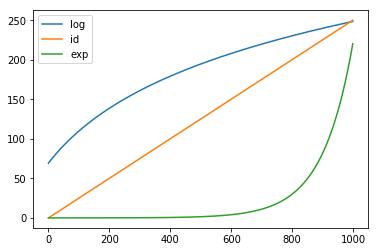

In [17]:
x = np.linspace(0, 10, 1000)
y_ln = 100*np.log(x + 2).reshape(-1,1)
y_id = 25*x.reshape(-1,1)
y_exp = 0.01*np.exp(x).reshape(-1,1)
y_joined_ln_first = np.dstack((y_ln, y_exp, y_id)).reshape(-1, 3)

plt.plot(y_ln, label = "log")
plt.plot(y_id, label = "id")
plt.plot(y_exp, label = "exp")
plt.legend()
plt.show()

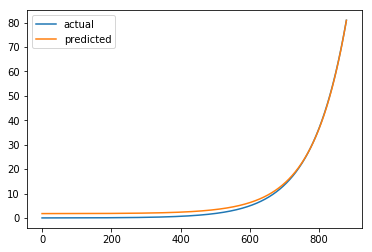

Mean error on train set: 1.4524424029765213


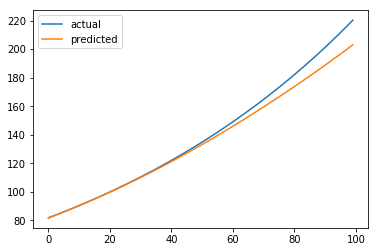

Mean error on test set: 6.262331031598967


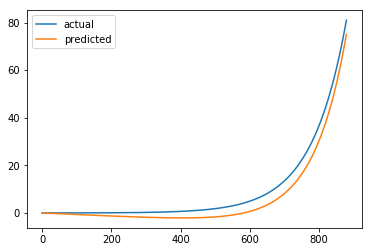

Mean error on train set: 3.7526014184066683


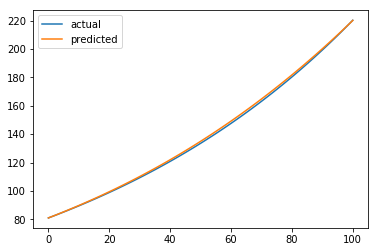

Mean error on test set: 1.09953875482668


In [13]:
_ = predict_non_stat(y_exp, 100, 20, 10, 50, 1, verbosity = 0)
_ = predict_stat(y_exp, 100, 20, 10, 50, 1, verbosity = 0)

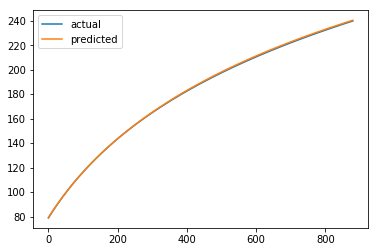

Mean error on train set: 0.5339712569077925


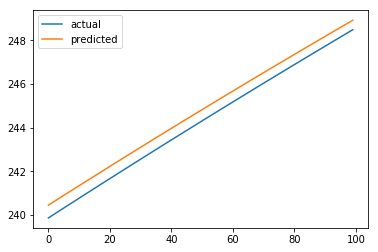

Mean error on test set: 0.515893787749509


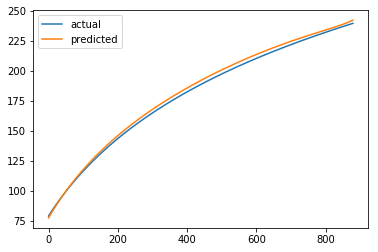

Mean error on train set: 2.2706340540770853


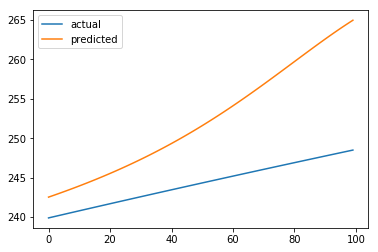

Mean error on test set: 13.554774400613288


In [21]:
_ = predict_non_stat(y_ln, 100, 20, 10, 50, 1, verbosity = 0)
_ = predict_non_stat(y_joined_ln_first, 100, 20, 10, 50, 2, verbosity = 0)

## Example 2 - beijing polution forecast

In [23]:
df = pd.read_csv('data/beijing.csv')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [29]:
df.tail(2)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0
43823,43824,2014,12,31,23,12.0,-21,-3.0,1034.0,NW,249.85,0,0


## Transform the data to desired form

In [26]:
df_no_na = df.fillna(df['pm2.5'].mean())
df_wind_OH = pd.get_dummies(df_no_na['cbwd'])
df_joined = pd.concat([df_no_na, df_wind_OH], axis=1, join_axes=[df_no_na.index])
df_ready = df_joined.drop(['No', 'cbwd', 'year', 'month', 'day', 'hour'], axis = 1)
df_ready.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
0,98.613215,-21,-11.0,1021.0,1.79,0,0,0,1,0,0
1,98.613215,-21,-12.0,1020.0,4.92,0,0,0,1,0,0
2,98.613215,-21,-11.0,1019.0,6.71,0,0,0,1,0,0
3,98.613215,-21,-14.0,1019.0,9.84,0,0,0,1,0,0
4,98.613215,-20,-12.0,1018.0,12.97,0,0,0,1,0,0


## np array to feed it to the functions

In [32]:
np_data = df_ready.values
np_data.shape
truncated_data = np_data[:5500]

Epoch 1/5
4999/4999 [==============================] - 12s 2ms/step - loss: 0.0396
Epoch 2/5
4999/4999 [==============================] - 4s 782us/step - loss: 0.0113
Epoch 3/5
4999/4999 [==============================] - 4s 785us/step - loss: 0.0095
Epoch 4/5
4999/4999 [==============================] - 4s 788us/step - loss: 0.0087
Epoch 5/5
4999/4999 [==============================] - 4s 784us/step - loss: 0.0082


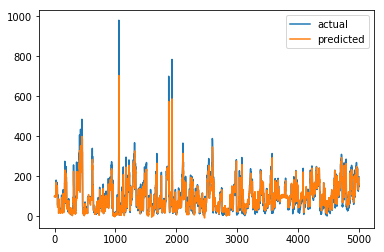

Mean error on train set: 32.153041362450566


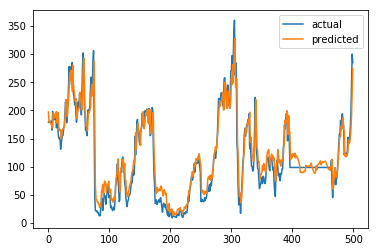

Mean error on test set: 22.57061583163056


In [33]:
_ = predict_non_stat(truncated_data, 500, 1, 5, 20, 1, verbosity = 1)

Epoch 1/5
4980/4980 [==============================] - 31s 6ms/step - loss: 0.0234
Epoch 2/5
4980/4980 [==============================] - 21s 4ms/step - loss: 0.0138
Epoch 3/5
4980/4980 [==============================] - 21s 4ms/step - loss: 0.0124
Epoch 4/5
4980/4980 [==============================] - 21s 4ms/step - loss: 0.0108
Epoch 5/5
4980/4980 [==============================] - 21s 4ms/step - loss: 0.0102


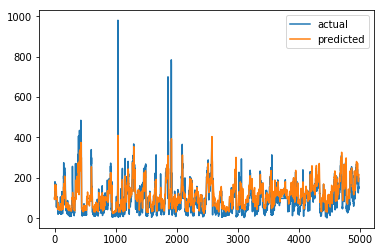

Mean error on train set: 43.010846794746364


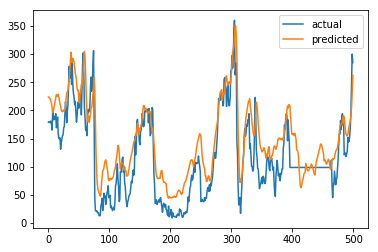

Mean error on test set: 44.78617446424852


In [35]:
_ = predict_non_stat(truncated_data, 500, 20, 5, 20, 1, verbosity = 1)